# Tworzenie sieci neuronowej

W tym zadaniu stworzymy w pełni połączoną sieć neuronową przy użyciu niskopoziomowych mechanizmów tensorflow.

Architektura sieci neuronowej została przedstawiona na poniższym rysunku. Jak widać, ma ona jedną warstwę wejściową, dwie warstwy ukryte i warstwę wyjściową. W warstwach ukrytych wykorzystamy sigmoid jako funkcję aktywacji. Na warstwie wyjściowej użyjemy softmax.

Część kodu do utworzenia sieci została już napisana, musisz wypełnić puste miejsca w określonych miejscach.

## Architektura sieci neuronowej

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Informacje o zestawie danych MNIST

Będziemy trenować tę sieć neuronową na zbiorze danych MNIST. Ten zbiór danych to duża liczba odręcznych obrazów cyfr składających się z 28 razy 28 pikseli. Każdy piksel przyjmuje wartość od 0 do 255.

Tak jak poprzednio, zbiór danych zostanie podzielony na próbki treningowe i testowe. Znormalizujemy wszystkie obrazy tak, aby wartości pikseli wynosiły od 0 do 1, dzieląc jasność każdego piksela przez 255.

Ponadto architektura sieci neuronowej oczekuje wektora jako danych wejściowych. W naszym przypadku jednak każdy przykładowy obiekt jest macierzą. Co należy zrobić? W tym zadaniu "rozciągniemy" macierz 28 razy 28$, uzyskując w ten sposób wektor składający się z 784 elementów.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Więcej informacji na temat zbioru danych można znaleźć na stronie [tutaj](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
num_classes = 10 # całkowita liczba klas, w naszym przypadku są to liczby od 0 do 9
num_features = 784 # liczba atrybutów wektora wejściowego 28 * 28 = 784

learning_rate = 0.001 # szybkość uczenia się sieci neuronowej
training_steps = 3000 # maksymalna liczba epok
batch_size = 256 # przeliczymy wagi sieci nie na całej próbce, ale na jej losowym podzbiorze elementów bat
display_step = 100 # co 100 iteracji pokażemy aktualną wartość funkcji straty i dokładności

n_hidden_1 = 128 # liczba neuronów warstwy 1
n_hidden_2 = 256 # liczba neuronów warstwy 2

In [3]:
from tensorflow.keras.datasets import mnist

# Ładowanie zestawu danych
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Konwersja pikseli całkowitych na typ float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Konwertujemy macierze 28x28 pikseli na wektor składający się z 784 elementów
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Normalizacja wartości pikseli
x_train, x_test = x_train / 255., x_test / 255.

# Zmiksujmy dane treningowe
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
# Stwórzmy sieć neuronową

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        # Miejsce na kod
        self.w = tf.Variable(
        tf.random.normal([in_features, out_features]), name="w"
      )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x):
        # Miejsce na kod
        y = tf.matmul(x, self.w) + self.b
        return tf.nn.relu(y)


class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    in_out = [num_features, n_hidden_1, n_hidden_2, num_classes]
    layers = []

    # Tworzenie warstw
    for i in range(len(in_out)-1):
      layers.append(DenseLayer(in_out[i], in_out[i+1], "layer"))

    self.layers = layers

  def __call__(self, x):
     i = 0
     n = len(self.layers) # 3

     for layer in self.layers:
      i += 1
      x = layer(x)

      if i < n:
        x = tf.nn.relu(x) # 1, 2
      else:
        x = tf.nn.softmax(x) # 3


     return x

In [5]:
# W tym przypadku wygodnie jest przyjąć entropię krzyżową jako funkcję błędu
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.0)

    # Obliczanie entropii krzyżowej
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1))

# Jako miernik jakości stosujemy dokładność
def accuracy(y_pred, y_true):
    #y_true = tf.argmax(y_true, axis=1)
    y_pred = tf.argmax(y_pred, axis=1)
    m = tf.keras.metrics.Accuracy()
    m.update_state(y_true, y_pred)

    return m.result().numpy()

In [6]:
# Stwórzmy przykładową sieć neuronową
neural_net = NN(name="mnist")

# Funkcja treningu sieci neuronowej
def train(nn, input_x, output_y):
  # Do dopasowania wag sieci wykorzystamy stochastyczne zejście gradientowe
  optimizer = tf.optimizers.SGD(learning_rate)

  # Aktywacja automatycznego różnicowania
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)
     # Utwórz zoptymalizowaną listę parametrów
    variables = nn.variables
    # Oblicz na ich podstawie wartość gradientu
    gradient = g.gradient(loss, variables)
    # Zmodyfikuj parametry
    optimizer.apply_gradients(zip(gradient, variables))

In [7]:
# Szkolenie sieciowe

loss_history = []  # każdy krok display_step zapisuje bieżący błąd sieci neuronowej na tej liście
accuracy_history = [] # każdy krok display_step zapisuje aktualną dokładność sieci neuronowej na tej liście
displays_steps = []

# W tej pętli będziemy trenować sieć neuronową
# Z treningowego zbioru danych train_data, wyodrębnij losowy podzbiór, na którym
# będzie trenowana. Użyj metody take dostępnej dla szkoleniowego zbioru danych.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps)):
    # Aktualizacja wag sieci neuronowej

    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:

        pred = neural_net(batch_x)
        loss=cross_entropy(pred, batch_y)
        acc=accuracy(pred, batch_y)
        loss_history.append(loss.numpy())
        accuracy_history.append(acc)
        displays_steps.append(step)



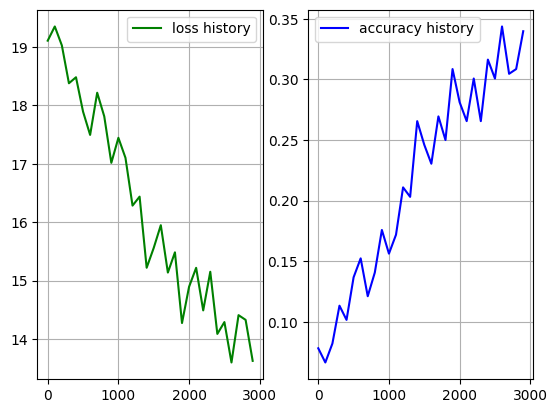

In [8]:
# Wykreśl zmianę dokładności i strat jako funkcję skoku
# Jeśli zostanie to zrobione poprawnie, dokładność powinna wzrosnąć, a straty powinny się zmniejszyć.

plt.subplot(1, 2, 1)
plt.plot(displays_steps, loss_history, color='g')
plt.grid(True)
plt.legend(["loss history"])
plt.subplot(1, 2, 2)
plt.plot(displays_steps, accuracy_history, color='b')
plt.grid(True)
plt.legend(["accuracy history"])

In [9]:
# Oblicz dokładność wytrenowanej sieci neuronowej

acc = accuracy(neural_net(x_test), y_test)
print(acc)

0.3068


1


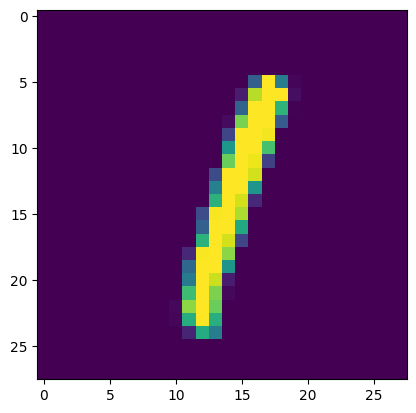

In [11]:
# Przetestuj wytrenowaną sieć neuronową na 10 obrazach. Z próbki testowej wybierz 5
# losowych obrazów i wprowadź je do sieci neuronowej.
# Wyprowadź obraz i zapisz obok niego odpowiedź sieci neuronowej.
# Czy sieć neuronowa się myli, a jeśli tak, to jak często?

sample_num = 5
x1 = x_test[sample_num].reshape(28, 28)
print(y_test[sample_num])
plt.imshow(x1)

6


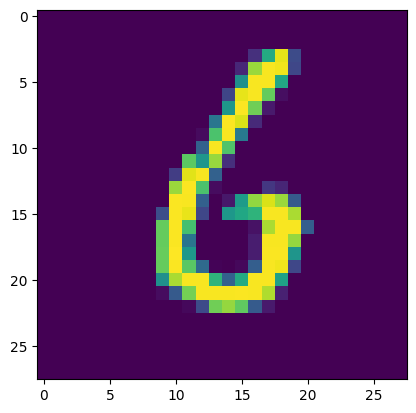

In [12]:
sample_num = 50
x1 = x_test[sample_num].reshape(28, 28)
print(y_test[sample_num])
plt.imshow(x1)

7


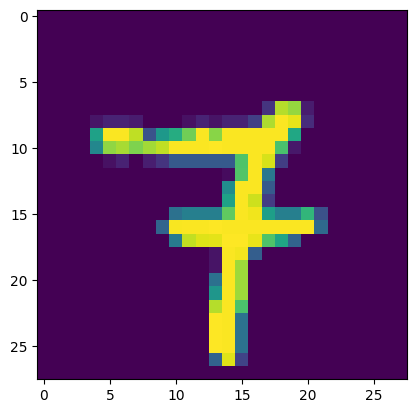

In [13]:
sample_num = 75
x1 = x_test[sample_num].reshape(28, 28)
print(y_test[sample_num])
plt.imshow(x1)

2


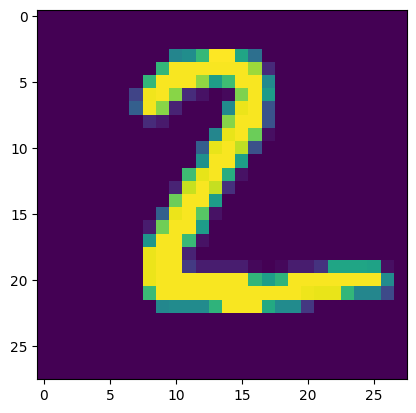

In [14]:
sample_num = 1
x1 = x_test[sample_num].reshape(28, 28)
print(y_test[sample_num])
plt.imshow(x1)

3


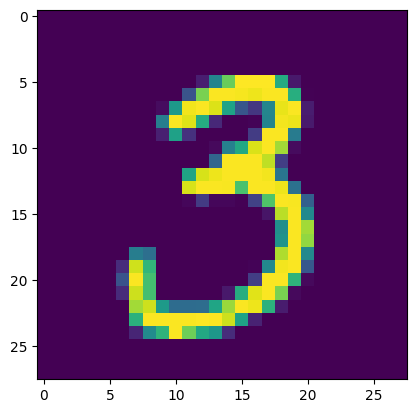

In [15]:
sample_num = 90
x1 = x_test[sample_num].reshape(28, 28)
print(y_test[sample_num])
plt.imshow(x1)

In [ ]:
# W moim przypadku sieć neuronowa nie pomyliła się ani razu